<a href="https://colab.research.google.com/github/bhavanabalraj/Federated-Learning/blob/master/FLWorkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install syft

In [0]:
import torch as tc
from torchvision import datasets, transforms
import syft as sy 

hook = sy.TorchHook(tc)

bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])])

trainset = datasets.FashionMNIST('./F_MNIST_data', download=True, train=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
trainloader = sy.FederatedDataLoader(trainset.federate((bob,alice)), batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('./F_MNIST_data', download=True, train=False, transform=transform)
testloader = tc.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
  
  def __init__(self):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)

    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):

    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = F.log_softmax(self.output(x), dim=1)

    return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001)

from syft.federated.floptimizer import Optims
workers = ['bob', 'alice']
optims = Optims(workers, optim=optim.Adam(params=model.parameters(),lr=0.001))

In [60]:
epochs = 5
steps = 0

training_loss, testing_loss = [],[]
for e in range(epochs):
  
  running_loss = 0
  
  for images, labels in trainloader:

    model.send(images.location)
    
    optimizer = optims.get_optim(images.location.id)
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    model.get()

    running_loss += loss.get()

  else:
    test_loss = 0
    accuracy = 0

    with tc.no_grad():
      
      model.eval()

      for images, labels in testloader:
        log_ps = model(images)
        test_loss = criterion(log_ps, labels)
        test_loss += test_loss.item()

        ps = tc.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += tc.mean(equality.type(tc.FloatTensor))

    model.train()
    
    training_loss.append(running_loss/len(trainloader))
    testing_loss.append(test_loss/len(testloader))

    print("Epochs :{}/{}".format(e+1, epochs),
    "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
    "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
    "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs :1/5 Training Loss: 0.601..  Test Loss: 0.004..  Test Accuracy: 0.835
Epochs :2/5 Training Loss: 0.437..  Test Loss: 0.002..  Test Accuracy: 0.854
Epochs :3/5 Training Loss: 0.396..  Test Loss: 0.004..  Test Accuracy: 0.855
Epochs :4/5 Training Loss: 0.373..  Test Loss: 0.002..  Test Accuracy: 0.869
Epochs :5/5 Training Loss: 0.358..  Test Loss: 0.003..  Test Accuracy: 0.870


--2020-05-17 17:30:52--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-05-17 17:30:53 (45.6 MB/s) - ‘helper.py’ saved [2813/2813]



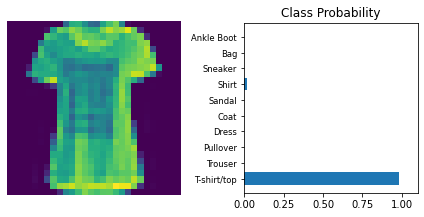

In [61]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
import helper

dataiter = iter(testloader)
images,labels = dataiter.next()
image = images[0]

img = image.view(1,784)

model.eval()

with tc.no_grad():
  output = model(img)

ps = tc.exp(output)
model.train()

helper.view_classify(img, ps, version='Fashion')